# Tutorial 1 - Basics

### Running from a config file
The simplest way to run an expereiment is to pass in a config file with all experiement options

In [ ]:
from DiffusionProject.JobManager.config import Config


config_path = "DiffusionProject/JobManager/Configs/DecoherenceDebug.yml"

config = Config(config_path)
experiment = config._gen_experiment_from_config()
experiment.run_locally()

### Writing a Config file
let's examine the body of a basic `config.yml` file:

In [ ]:
Name: "Decoherence_debug"

ExperimentParams:
  NSteps: 20
  NDims: 1
  NQubits: 5
  Coin: "Hadamard"
  InitialState: "auto"

  Boundaries:
    - Type: "Hard"
      Geometry: "Edges"
      Padding: 0
      Dim: 0
  
  InitialState: "auto"
  Shots: 2048
  DecoherenceIntervals: 6

OutputPath: "/Users/Ali/Downloads"

The quantum walk params are defined under the `ExperimentParams` header
- `NDims` : the number of dimensions in physical space to simulate
- `NQubits` the number of qubits used to simulate each dimension
- `Coin` the shift coin operator class
- `InitialState` the state to start the walk in. For example "0000 0000" will start in the bottom left corner of a 4 qubit system. the `auto` argument will initialise in the centre
- `Boundaries` These describe the boundary conditions. Boundaries can either be dexcribed using a `Geometry` or a `Bitstring`. use the `Type` argumnent to toggle between `hard` and `soft` boundaries 
- `Shots` the number of shots to run the experiment for
- `DecoherenceIntervals` the length of each walk in number of steps before decohering. ommiting this parameter will not decohere the walk

### Generating a quantum walk experiment from classes

First we need to import all the necessary classes and instantiate a simulated quantum backend. Instantiating a Backend with no arguments will generate a simulation of a perfect quantum computer

In [10]:
from DiffusionProject.Algorithms.Walks import QuantumWalk2D
from DiffusionProject.Backends.backend import Backend
from DiffusionProject.Algorithms.Boundaries import BoundaryControl, Boundary
from DiffusionProject.Algorithms.Coins import GroverCoin

BACKEND = Backend()

running on device: CPU
Backend: aer_simulator


Next we need to generate boundary conditions. The steps to doing so are to first generate the boundary geometries as `Boundary` objects, then to pass them to `BoundaryControls` Boundary controls can be used to add controls such as quantum coins to the boundaries it manages

In [9]:
boundary_right_edge = Boundary("111",0)
boundary_left_edge = Boundary("000",0)
boundary_top_edge = Boundary("111",1)
boundary_bottom_edge = Boundary("000",1)
boundaries = [boundary_right_edge, boundary_bottom_edge, boundary_left_edge, boundary_right_edge]
hard_control = BoundaryControl()
hard_control.add_boundaries(boundaries)

Now we can generate our quantum walk. we can use the `step()` method to add a single application of the U operator. 

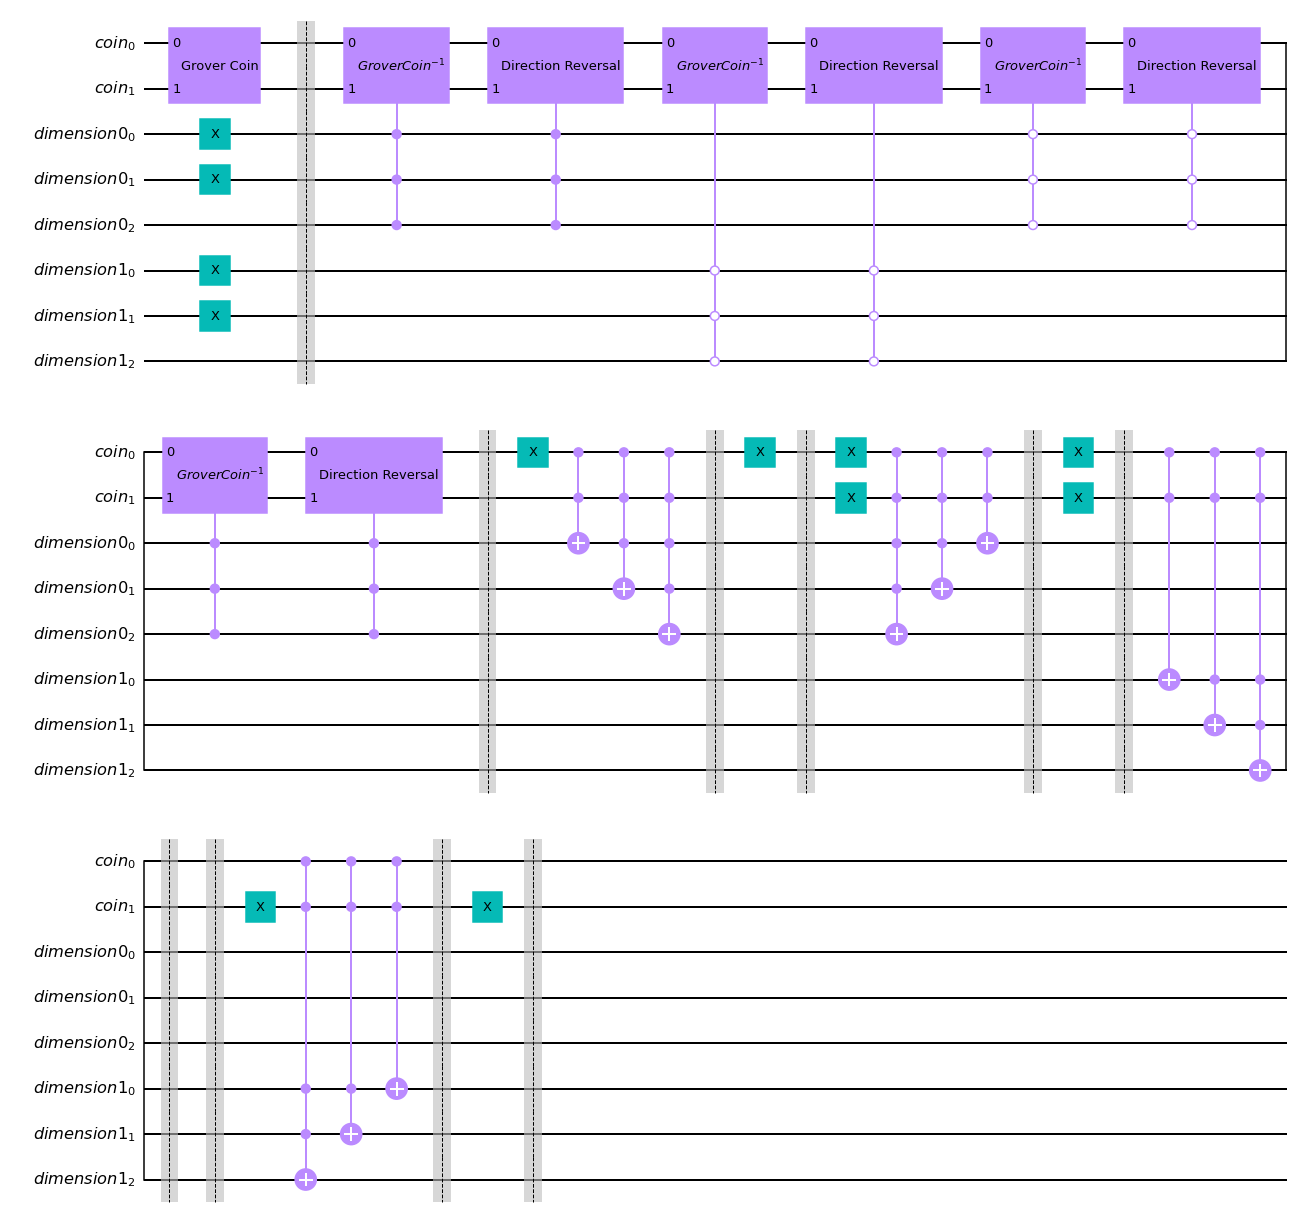

In [3]:
walk = QuantumWalk2D(BACKEND,[3,3],initial_states=["011","011"],coin_class=GroverCoin, boundary_controls=[hard_control])
walk.step()
walk.quantum_circuit.draw('mpl')

We can now run a quantum walk and generate results

In [4]:
job = walk.run_experiment(n_steps = 10, shots=1048)
results = walk.get_results(job)

/Volumes/Extreme SSD/AEROY4/Simulation-of-a-Quantum-Computer/qiskit-env/lib/python3.7/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


We can now plot our results

Text(0.5, 1.0, 'diffusion on an 8x8 grid')

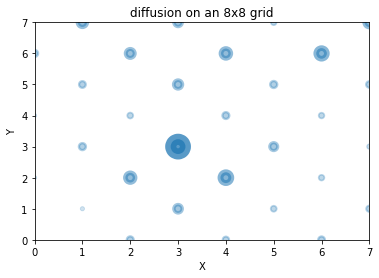

In [7]:
from matplotlib import pyplot as plt

x,y,probability_density = results["dimension_0"],results["dimension_1"],results["probability_density"]
axes_limit = (2**3)-1

title = "diffusion on an {0}x{0} grid".format(axes_limit+1)

alpha = [i**(1/4) for i in probability_density]
 

plt.scatter(x,y,alpha=alpha,linewidths=[20*i**0.5 for i in probability_density], s = [400*i**0.5 for i in probability_density])
plt.xlim(0,axes_limit)
plt.ylim(0,axes_limit)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(title)

### Running a Dechorence Experiment
We can use the `run_decoherence_experiment()` method to run a decohered experiment.

In [13]:
from DiffusionProject.Algorithms.Walks import QuantumWalk1D
from DiffusionProject.Algorithms.Coins import HadamardCoin
BACKEND = Backend()
boundary_right_edge = Boundary("11111",0)
boundary_left_edge = Boundary("00000",0)
boundaries = [boundary_right_edge, boundary_left_edge]
hard_control = BoundaryControl()
hard_control.add_boundaries(boundaries)
walk = QuantumWalk1D(BACKEND,5,initial_states="01111",coin_class=HadamardCoin, boundary_controls=[hard_control])
results, time_taken = walk.run_decoherence_experiment(n_steps=20,decoherence_intervals=6,return_elapsed_time=True)

running on device: CPU
Backend: aer_simulator
decohenerence cycle 1


/Volumes/Extreme SSD/AEROY4/Simulation-of-a-Quantum-Computer/qiskit-env/lib/python3.7/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


decohenerence cycle 2
decohenerence cycle 3
decohenerence cycle 4


Text(0.5, 1.0, 'diffusion on an 32 digit line')

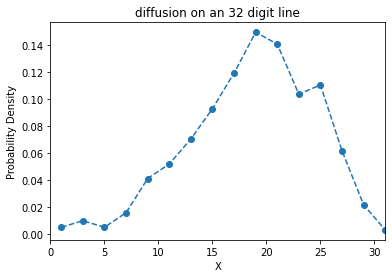

In [14]:
x,probability_density = results["dimension_0"],results["probability_density"]
axes_limit = (2**5)-1
 
title = "diffusion on an {0} digit line".format(axes_limit+1)

coords = [(i,j) for i,j in zip(x,probability_density)]
coords.sort(key=lambda coord: coord[0])
x_sorted = [coord[0] for coord in coords]
probability_sorted = [coord[1] for coord in coords]


plt.plot(x_sorted,probability_sorted,'o--')
plt.xlim(0,axes_limit)
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.title(title)